# System Overview

This notebook outlines a two-step approach:

1. **Ranking System with Embeddings**  
   Initially, we employ a ranking system based on embeddings. This involves generating vector representations of text data using pre-trained models or custom embeddings. These embeddings allow us to compute similarity scores, enabling the ranking of documents, sentences, or queries based on their relevance to a given input.

2. **Binary Classification with Transformers (BERT-like)**  
   Once the ranking system has narrowed down the candidates, a binary classification model based on a transformer architecture (e.g., BERT) is applied. This classifier further refines the results by determining whether each candidate is relevant (`1`) or not (`0`). The use of transformers ensures high accuracy and robustness in this final decision-making step.


## Imports

In [1]:
import pandas as pd
import numpy as np
import random
from sentence_transformers import SentenceTransformer, util
from sklearn.metrics import classification_report
import heapq
from transformers import XLMRobertaTokenizer, Trainer, TrainingArguments, BertForSequenceClassification
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from sklearn.utils.class_weight import compute_class_weight
from torch.nn import CrossEntropyLoss
import os
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from peft import LoraConfig, TaskType, get_peft_model
import tqdm
import pickle as pkl
import gc
import ipywidgets as widgets
from IPython.display import display, HTML, clear_output
import matplotlib.pyplot as plt


In [ ]:
EMBEDDING_MODEL = "sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2"
DATA_PICKLE_TR = "data/claims_tr.pkl"
DATA_PICKLE_TE = "data/claims_te.pkl"
CSV_PATH = "data/claim_matching_dataset.csv"
BATCH_SIZE = 24
EPOCHS = 15
TH = 0.5
topK = 15
TRAIN = False
gradient_checkpointing = False
MAX_TOKENS = 512
# Configuración del modelo y tokenizer
# MODEL_NAME = "microsoft/Multilingual-MiniLM-L12-H384"
# name = "ML_MiniLM"
MODEL_NAME = "Qwen/Qwen2.5-3B-Instruct-GPTQ-Int4"
name="Qwen2.5-3B-Instruct"
use_peft = "qwen" in MODEL_NAME.lower()
if "qwen" in MODEL_NAME.lower():
    BATCH_SIZE = 2
    EPOCHS = 4
    gradient_checkpointing = True
    MAX_TOKENS = 3000


# Data and embedding preparations

## Device and Embedding Model Initialization

- The `device` is set to `"cuda"`, indicating that computations will run on a GPU if available, which significantly speeds up the embedding process.
- A pre-trained model, `paraphrase-multilingual-MiniLM-L12-v2`, from the `SentenceTransformer` library is loaded. This model generates embeddings for text and supports multiple languages, making it suitable for multilingual tasks.
- The model is initialized on the specified device for efficient processing.


In [3]:
device = "cuda"
embedding_model = SentenceTransformer(EMBEDDING_MODEL, device=device)

## Selected Columns for the Ranking System

- **query_col**: Represents the unverified claim.
- **archive**: Refers to the reviewed claim.

In [4]:
query_col = "unverified claim"
archive = "reviewed claim"

## Loading and Preparing the Dataset

The dataset is loaded from a CSV file located at `data/claim_matching_dataset.csv`. The file should have two key columns:
- **`unverified claim`**: Contains new, unverified claims that need to be matched.
- **`reviewed claim`**: Contains previously reviewed and verified claims.

The column names are defined as `"unverified claim"` and `"reviewed claim"`. Missing values in these columns are replaced with empty strings (`''`) to ensure data consistency, and all entries are converted to strings for text processing.


In [5]:
def preprocess_data(data_path):
    
    data = pd.read_csv(data_path, delimiter=",", quotechar='"', encoding='utf-8')

    # Reemplazar valores nuls con cadenas vacías
    data[query_col] = data[query_col].fillna('').astype(str)
    data[archive] = data[archive].fillna('').astype(str)

    uniq_queries = data[query_col].unique()
    ntest = 0.2
    total_test = int(len(uniq_queries) * ntest)
    random.shuffle(uniq_queries)
    test = uniq_queries[:total_test]
    train = uniq_queries[total_test:]
    print(f"A total of {len(train)} number of unique exampels for train and {len(test)} for test")

    filtered_train = data[data[query_col].isin(train)]
    filtered_test = data[data[query_col].isin(test)]
    print(len(filtered_train))
    print(len(filtered_test))
    print(len(data))

    return filtered_train, filtered_test

In [6]:

# Function: Load and Process Data
def load_and_process_data():
    if os.path.exists(DATA_PICKLE_TR):
        print("Loading processed data from pickle...")
        tr, te = pd.read_pickle(DATA_PICKLE_TR), pd.read_pickle(DATA_PICKLE_TE)
        return tr, te

    print("Processing raw data from CSV...")
    filtered_train, filtered_test = preprocess_data(CSV_PATH)

    # Generate embeddings

    filtered_test.loc[:, 'query_embedding'] = filtered_test[query_col].apply(lambda x: embedding_model.encode(x, convert_to_tensor=True))
    filtered_test.loc[:, 'archive_embedding'] = filtered_test[archive].apply(lambda x: embedding_model.encode(x, convert_to_tensor=True))
    filtered_train.loc[:, 'query_embedding'] = filtered_train[query_col].apply(lambda x: embedding_model.encode(x, convert_to_tensor=True))
    filtered_train.loc[:, 'archive_embedding'] = filtered_train[archive].apply(lambda x: embedding_model.encode(x, convert_to_tensor=True))
    filtered_test["metadata_combined"] = filtered_test.apply(
    lambda row: (
        f"Título: {row['title']}\n"
        f"Texto: {row['text']}\n"
        f"Meta Descripción: {row['meta_description']}\n"
        f"Resumen: {row['summary']}\n"
        f"KB Keywords: {row['kb_keywords']}\n"
        f"Meta Keywords: {row['meta_keywords']}\n"
        f"URL: {row['url']}\n"
        f"Dominio: {row['domain']}\n"
        f"País CR: {row['cr_country']}\n"
        f"Meta Lenguaje: {row['meta_lang']}"
    ),
    axis=1
    )
    filtered_train["metadata_combined"] = filtered_test.apply(
    lambda row: (
        f"Título: {row['title']}\n"
        f"Texto: {row['text']}\n"
        f"Meta Descripción: {row['meta_description']}\n"
        f"Resumen: {row['summary']}\n"
        f"KB Keywords: {row['kb_keywords']}\n"
        f"Meta Keywords: {row['meta_keywords']}\n"
        f"URL: {row['url']}\n"
        f"Dominio: {row['domain']}\n"
        f"País CR: {row['cr_country']}\n"
        f"Meta Lenguaje: {row['meta_lang']}"
    ),
    axis=1
    )

    # Save processed data
    filtered_train.to_pickle(DATA_PICKLE_TR)
    filtered_test.to_pickle(DATA_PICKLE_TE)

    print("Data processing complete. Pickle saved.")
    return filtered_train, filtered_test

## Generating Embeddings for the Test Set

Embeddings are generated for the test set using the pre-trained `embedding_model`:
- For each `query` in the test set, embeddings are computed and stored in the `query_embedding` column. The `embedding_model.encode` method converts the text into a tensor representation.
- Similarly, embeddings are computed for each `archive` entry in the test set and stored in the `archive_embedding` column.
- This process transforms the textual data into dense vector representations, which can be used for similarity computations.


In [7]:
filtered_train, filtered_test = load_and_process_data()

Loading processed data from pickle...


## Creating a Dictionary for Query-to-Answers Mapping

Constructs a dictionary that maps each unverified claim (`query`) to all verified claims (`archive`) associated with it in the test set:

- Filters the rows in `filtered_test` where the `similarity` column equals `1` (indicating a match).
- Groups the filtered rows by the `query` column, selecting the corresponding values from the `archive` column.
- Converts the grouped values of `archive` into sets to ensure each query has a unique list of verified claims.
- Converts the resulting mapping into a dictionary (`query_answer_dict`) where keys are queries and values are sets of verified claims.

Additionally:
- `uniq_queries_test` holds the set of unique queries in the test set.
- `uniq_verified_test` holds the set of unique verified claims in the test set.

The sizes of the resulting dictionary, unique queries, and unique verified claims are printed for verification.


In [8]:
query_answer_dict = (
    filtered_test[filtered_test["similarity"] == 1]  # Filter rows where similarity is 1 or True
    .groupby(query_col)[archive]                    # Group by the "query" column and select "archive"
    .apply(set)                                     # Convert the values of "archive" to a set
    .to_dict()                                      # Convert the result to a dictionary
)
uniq_queries_test = set(filtered_test[query_col].unique())
uniq_verified_test = set(filtered_test[archive].unique())
# Print the resulting dictionary
print(len(query_answer_dict))
print(len(uniq_queries_test))
print(len(uniq_verified_test))

44
47
680


## Handling Queries Without Similarity Matches

Identifies queries in the test set that have no matching verified claims and ensures they are included in the `query_answer_dict`:

- Iterates through all unique queries in the test set (`uniq_queries_test`).
- For any query not already present as a key in `query_answer_dict`, it:
  - Prints the query to indicate it has no similarity matches.
  - Adds the query to the dictionary with an empty set as its value, representing no associated verified claims.
  
Finally, the sizes of the updated dictionary, the set of unique queries, and the set of unique verified claims are printed for verification.


In [9]:
for k in uniq_queries_test:
    if k not in query_answer_dict.keys():
        print(f"Query sin answer : {k}")
        query_answer_dict[k] = set()
# Print the resulting dictionary
print(len(query_answer_dict))
print(len(uniq_queries_test))
print(len(uniq_verified_test))

Query sin answer : España ha multiplicado por cuatro su dependencia del gas ruso
Query sin answer : pablo iglesias compra pan en un coche oficial
Query sin answer : video de putin anunciando invasion tres dias antes de la guerra
47
47
680


# Binary classifier


## Splitting Training Data into Training and Validation Sets

`filtered_train` is divided into two subsets:
- **Training set (90%)**: Used to train the model.
- **Validation set (10%)**: Used to evaluate the model during training and fine-tuning.

The split is performed using the `train_test_split` function with the following parameters:
- `test_size=0.1`: Allocates 10% of the data to the validation set.
- `random_state=42`: Ensures reproducibility by fixing the random seed.

The sizes of both subsets are printed to confirm the split.


In [10]:
# Divide filtered_train en entrenamiento y val
train_data, val_data = train_test_split(
    filtered_train, test_size=0.1, random_state=42
)

# Verifica el tamaño de los conjuntos
print(f"Training size: {len(train_data)}")
print(f"Validation size: {len(val_data)}")

Training size: 2790
Validation size: 310


## 1. Dataset Definition

Defines a custom PyTorch `Dataset` class, `TextPairDataset`, to handle text pairs (`query`, `archive`) and their similarity labels. It tokenizes the pairs using a specified tokenizer.


In [ ]:
class TextPairDataset(Dataset):
    def __init__(self, df, tokenizer, max_length=MAX_TOKENS):
        self.queries = df[query_col].tolist()
        self.archives = df[archive].tolist()
        self.metadata_combined = df["metadata_combined"].tolist()
        self.labels = df["similarity"].tolist()
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.queries)

    def __getitem__(self, idx):
        query = self.queries[idx]
        archive = self.archives[idx]
        
        label = self.labels[idx]

        encoding = self.tokenizer(
            query,
            archive,
            max_length=self.max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt",
        )
        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "label": torch.tensor(label, dtype=torch.long),
        }

In [12]:
def print_number_of_trainable_model_parameters(model):  
    trainable_model_params = 0
    all_model_params = 0
    for _, param in model.named_parameters():
        all_model_params += param.numel()
        if param.requires_grad:
            trainable_model_params += param.numel()
    return f"trainable model parameters: {trainable_model_params}\nall model parameters: {all_model_params}\npercentage of trainable model parameters: {100 * trainable_model_params / all_model_params:.2f}%"


In [13]:

def get_latest_checkpoint(path):
    checkpoints = [folder for folder in os.listdir(path) if folder.startswith("checkpoint-") and folder.split("-")[-1].isdigit()]
    latest_checkpoint = max(checkpoints, key=lambda x: int(x.split("-")[-1]), default=None)
    return os.path.join(path, latest_checkpoint) if latest_checkpoint else None

In [14]:
def get_model(path, score_file_path=None):
    if not TRAIN:
        path = get_latest_checkpoint(path)
        print(f"Checkpoint path : {path}")
    if "MiniLM" in MODEL_NAME:
        tokenizer = XLMRobertaTokenizer.from_pretrained(path, device=device)
        model = BertForSequenceClassification.from_pretrained(path, 
                                                      num_labels=2,
                                                      problem_type="single_label_classification",
                                                      ).to(device)
    else:
        tokenizer = AutoTokenizer.from_pretrained(path)
        model = AutoModelForSequenceClassification.from_pretrained(
            path,
            num_labels=2,
            device_map=device,
        )
        if score_file_path is not None:
            with open(score_file_path, "rb") as f:
                model.score = pkl.load(f)
    return tokenizer, model

#### Auxiliary Cell: Clear GPU Memory

This cell ensures that GPU memory is cleared if the notebook is re-executed on the fly:
- Moves the model to the CPU and deletes it.
- Deletes the tokenizer if it exists.
- Performs garbage collection and clears the CUDA cache.

In [15]:
try:
    model.to("cpu")
    del model
except:
    pass
try:
    del tokenizer
except:
    pass
gc.collect()
torch.cuda.empty_cache() 

In [16]:
output_dir = f"./results_{name}"
score_file_path = os.path.join(output_dir, "score.pkl")
if TRAIN:
    tokenizer, model = get_model(MODEL_NAME)
    if use_peft:
        lora_target_modules = [
                "q_proj",
                "k_proj",
                "v_proj",
                "o_proj",
                "gate_proj",
                "up_proj",
                "down_proj",
        ]
        lora_config = LoraConfig(
            r=16,  # Rank
            lora_alpha=32,
            target_modules=lora_target_modules,
            lora_dropout=0.05,
            bias="none",
            # task_type=TaskType.SEQ_CLS,
            task_type=TaskType.CAUSAL_LM, # Looks like there is some kind of error if i set SEQ_CLS
        )
        peft_model = get_peft_model(model, lora_config)
        model = peft_model
    print(print_number_of_trainable_model_parameters(model))
    if gradient_checkpointing and TRAIN:
        model._prepare_model_for_gradient_checkpointing
    # model = peft_model
    
    training_args = TrainingArguments(
        output_dir=output_dir,
        evaluation_strategy="epoch",
        learning_rate=2e-5,
        per_device_train_batch_size=BATCH_SIZE,
        per_device_eval_batch_size=BATCH_SIZE,
        num_train_epochs=EPOCHS,
        weight_decay=0.01,
        save_strategy="epoch",
        save_total_limit=1,
        logging_dir='./logs',
        logging_steps=50,
        push_to_hub=False,
        load_best_model_at_end=True,
        bf16=True,  
        gradient_checkpointing=gradient_checkpointing,
        gradient_checkpointing_kwargs={"use_reentrant": False},
    )
else:
    tokenizer, model = get_model(output_dir, score_file_path)
train_dataset = TextPairDataset(train_data, tokenizer)
val_dataset = TextPairDataset(val_data, tokenizer)
model.config.pad_token_id = tokenizer.pad_token_id

# Definir la función para calcular métricas
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1, "precision": precision, "recall": recall}


Checkpoint path : ./results_Qwen2.5-3B-Instruct/checkpoint-2790


/home/jose/anaconda3/envs/factcheck/lib/python3.11/site-packages/auto_gptq/nn_modules/triton_utils/kernels.py:410: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @custom_fwd
/home/jose/anaconda3/envs/factcheck/lib/python3.11/site-packages/auto_gptq/nn_modules/triton_utils/kernels.py:418: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  @custom_bwd
/home/jose/anaconda3/envs/factcheck/lib/python3.11/site-packages/auto_gptq/nn_modules/triton_utils/kernels.py:461: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @custom_fwd(cast_inputs=torch.float16)
CUDA extension not installed.
CUDA extension not installed.
/home/jose/anaconda3/envs/factcheck/lib/python3.11/site-packages/transformers/modeling_utils.py:5055: FutureW

## 6. Train the model

In [17]:
if TRAIN:
    if "qwen" not in MODEL_NAME.lower():
        class_weights = compute_class_weight(
            class_weight='balanced',
            classes=np.unique(train_data["similarity"]),
            y=train_data["similarity"]
        )
        class_weights = torch.tensor(class_weights, dtype=torch.float).to(model.device)
        # Define a custom loss function
        def compute_loss_func(output, labels, return_outputs=False, **kwargs):
            """
            Custom loss function with class weights.
            Handles additional arguments passed by the Trainer.
            """
            # Define the loss function with class weights
            logits = output.logits.to(device)
            labels = labels.to(device)
            loss_fn = CrossEntropyLoss(weight=class_weights)
            loss = loss_fn(logits, labels)
            # Return loss and optionally model outputs
            return (loss, output) if return_outputs else loss
    else:
        compute_loss_func = None
    # 6. Train the model
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        tokenizer=tokenizer,
        compute_loss_func=compute_loss_func  # Custom loss function with class weights
    )
    trainer.train()
model.eval()

Qwen2ForSequenceClassification(
  (model): Qwen2Model(
    (embed_tokens): Embedding(151936, 2048)
    (layers): ModuleList(
      (0-35): 36 x Qwen2DecoderLayer(
        (self_attn): Qwen2SdpaAttention(
          (rotary_emb): Qwen2RotaryEmbedding()
          (k_proj): lora.QuantLinear(
            (base_layer): QuantLinear()
            (lora_dropout): ModuleDict(
              (default): Dropout(p=0.05, inplace=False)
            )
            (lora_A): ModuleDict(
              (default): Linear(in_features=2048, out_features=16, bias=False)
            )
            (lora_B): ModuleDict(
              (default): Linear(in_features=16, out_features=256, bias=False)
            )
            (lora_embedding_A): ParameterDict()
            (lora_embedding_B): ParameterDict()
            (lora_magnitude_vector): ModuleDict()
            (quant_linear_module): QuantLinear()
          )
          (o_proj): lora.QuantLinear(
            (base_layer): QuantLinear()
            (lora_dropo

### Manual Saving of the Score Layer

Since the `score` layer is not saved automatically due to an issue with Hugging Face, it is manually saved when training:
- For some models, the `score` layer is serialized and saved to a file.

In [18]:
if TRAIN:
    if "qwen" in MODEL_NAME.lower():
        with open(score_file_path, "wb") as f:
            pkl.dump(model.score, f)
        print(f"Score guardado en: {score_file_path}")

In [19]:
if TRAIN:
    os.makedirs(output_dir, exist_ok=True)
    tokenizer.save_pretrained(output_dir)
    model.save_pretrained(output_dir)


# Define the metrics


Implements functions to evaluate the model's performance:

- **`evaluate_classifier`**: Evaluates the Hugging Face model on a dataset and prints a classification report.
- **`map_at_k`**: Calculates mean average precision at various cutoff values (`k`) for ranking evaluation.
- **`recall_at_k`**: Computes recall at different `k` values, measuring the proportion of relevant items retrieved.
- **`mean_reciprocal_rank`**: Computes the mean reciprocal rank, reflecting how quickly relevant results appear in the predicted ranking.

These metrics provide a comprehensive evaluation of classification and ranking performance.

In [ ]:
# Define a function to evaluate the Hugging Face classifier
def evaluate_classifier(model, dataset, batch_size=BATCH_SIZE):
    """
    Evaluates the Hugging Face model on a given dataset.

    Args:
        model: The Hugging Face model to evaluate.
        dataset: The dataset for evaluation (custom PyTorch Dataset).
        tokenizer: The tokenizer corresponding to the model.
        batch_size: Batch size for evaluation.

    Returns:
        None (Prints the classification report).
    """
    # Create a DataLoader to process the dataset in batches
    dataloader = DataLoader(dataset, batch_size=batch_size)

    # Variables to store true labels and predicted labels
    all_labels = []
    all_preds = []

    # Set the model to evaluation mode
    model.eval()
    with torch.no_grad():  # Disable gradient calculations for evaluation
        for batch in tqdm.tqdm(dataloader):
            # Move input tensors to the same device as the model
            input_ids = batch["input_ids"].to(model.device)
            attention_mask = batch["attention_mask"].to(model.device)
            labels = batch["label"].cpu().numpy()  # Extract true labels

            # Perform predictions using the model
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            predictions = torch.argmax(logits, dim=-1).cpu().numpy()  # Get predicted classes

            # Store true labels and predictions for evaluation
            all_labels.extend(labels)
            all_preds.extend(predictions)

    # Generate and print the classification report
    print(classification_report(all_labels, all_preds, target_names=["No Similar", "Similar"]))

def calculate_accuracy_pipeline(gt_dict, results_dict):
    """
    Calculates the accuracy of predictions compared to ground truth, considering both correct and incorrect values.
    
    Args:
        gt_dict (dict): Ground truth dictionary where keys are queries and values are sets of correct answers.
        results_dict (dict): Predicted results dictionary where keys are queries and values are lists of predicted answers.
        
    Returns:
        float: Accuracy of the predictions as the average proportion of correct answers per query.
    """
    total_queries = len(gt_dict)
    total_accuracy = 0

    for query, gt_values in gt_dict.items():
        # Get the predicted values for the query
        predicted_values = results_dict.get(query, [])
        
        # Calculate the intersection of correct predictions
        correct_predictions = len(set(predicted_values) & gt_values)
        
        denominator = len(gt_values | set(predicted_values))  # Union of GT and predictions
        # denominator = len(gt_values)
        
        # Calculate the accuracy for this query
        query_accuracy = correct_predictions / denominator if denominator > 0 else 0
        total_accuracy += query_accuracy

    # Calculate overall accuracy as the average accuracy across all queries
    overall_accuracy = total_accuracy / total_queries if total_queries > 0 else 0
    return overall_accuracy

def map_at_k(gt_dict, hyp_dict, k_values):
    """
    Computes mean average precision at k (mAP@k) for ground truth and hypothesis dictionaries.

    Args:
        gt_dict (dict): Ground truth dictionary with query as key and a set of correct results as value.
        hyp_dict (dict): Hypothesis dictionary with query as key and a list of predicted results as value.
        k_values (list): List of k values for which mAP@k should be calculated.

    Returns:
        list: Mean Average Precision at each k in k_values.
    """
    map_scores = []

    for k in k_values:
        average_precisions = []
        
        for query, gt_values in gt_dict.items():
            if query in hyp_dict:
                top_k_predictions = hyp_dict[query][:k]
                num_relevant = 0
                precision_at_i_sum = 0
                
                for i, pred in enumerate(top_k_predictions, start=1):
                    if pred in gt_values:
                        num_relevant += 1
                        precision_at_i_sum += num_relevant / i  # Precision at rank i
                
                # Calculate Average Precision (AP) for this query
                if num_relevant > 0:
                    average_precisions.append(precision_at_i_sum / min(len(gt_values), k))
                elif num_relevant == 0 and len(gt_values) == 0:
                    average_precisions.append(1)
                else:
                    average_precisions.append(0)
        
        # Calculate mAP@k
        map_scores.append(np.mean(average_precisions))
    
    return map_scores


def recall_at_k(gt_dict, hyp_dict, k_values):
    """
    Computes recall at k for ground truth and hypothesis dictionaries.

    Args:
        gt_dict (dict): Ground truth dictionary with query as key and a set of correct results as value.
        hyp_dict (dict): Hypothesis dictionary with query as key and a list of predicted results as value.
        k_values (list): List of k values for which recall@k should be calculated.

    Returns:
        list: Recall at each k in k_values.
    """
    recalls = []

    for k in k_values:
        recall_scores = []
        
        for query, gt_values in gt_dict.items():
            if query in hyp_dict:
                top_k_predictions = hyp_dict[query][:k]
                if not isinstance(gt_values, set):
                    gt_values = set(gt_values)  # Ensure ground truth values are a set
                retrieved_relevant = len(set(top_k_predictions) & gt_values)  # Intersection of predictions and relevant items
                if len(gt_values) > 0:
                    recall = retrieved_relevant / min(len(top_k_predictions), k)
                else:
                    if len(gt_values) == 0 and retrieved_relevant == 0:
                        recall = 1
                    else:
                        recall = 0
                recall_scores.append(recall)
        
        # Average recall for this k
        recalls.append(np.mean(recall_scores))
    
    return recalls


def mean_reciprocal_rank(gt_dict, hyp_dict):
    """
    Computes mean reciprocal rank for ground truth and hypothesis dictionaries.
    """
    reciprocal_ranks = []
    for query, gt_values in gt_dict.items():
        if query in hyp_dict:
            for rank, pred in enumerate(hyp_dict[query], 1):
                if pred in gt_values:
                    reciprocal_ranks.append(1 / rank)
                    break
                elif len(pred) == 0 and len(gt_values) == 0:
                    reciprocal_ranks.append(1)
            else:
                if len(gt_values) == 0:
                    reciprocal_ranks.append(1)
                else:
                    reciprocal_ranks.append(0)
    return np.mean(reciprocal_ranks)

# Evaluation

## Evaluate the Classifier on the Val Set

Evaluates the classifier's performance on the validation set using the `evaluate_classifier` function. This evaluation focuses purely on the classification task, without considering the ranking system.


In [21]:
print("Evaluando clasificador en validación...")
evaluate_classifier(model, val_dataset)

Evaluando clasificador en validación...


100%|██████████| 155/155 [03:33<00:00,  1.38s/it]

              precision    recall  f1-score   support

  No Similar       0.95      0.98      0.97       243
     Similar       0.92      0.82      0.87        67

    accuracy                           0.95       310
   macro avg       0.93      0.90      0.92       310
weighted avg       0.94      0.95      0.94       310



## Evaluate the Classifier on the Training Set

Evaluates the classifier's performance on the training set using the `evaluate_classifier` function. This evaluation focuses purely on the classification task, without considering the ranking system.


In [22]:
print("Evaluating the classifier on the training set...")
evaluate_classifier(model, train_dataset)

Evaluating the classifier on the training set...


  0%|          | 0/1395 [00:00<?, ?it/s]

100%|██████████| 1395/1395 [32:18<00:00,  1.39s/it]

              precision    recall  f1-score   support

  No Similar       0.98      1.00      0.99      2122
     Similar       0.99      0.95      0.97       668

    accuracy                           0.99      2790
   macro avg       0.99      0.97      0.98      2790
weighted avg       0.99      0.99      0.99      2790



## Evaluate the Classifier on the Test Set

Evaluates the classifier's performance on the test set using the `evaluate_classifier` function. This evaluation focuses purely on the classification task, without considering the ranking system.

In [23]:
print("Evaluando clasificador en test...")
test_dataset = TextPairDataset(filtered_test, tokenizer)
evaluate_classifier(model, test_dataset)

Evaluando clasificador en test...


  0%|          | 0/384 [00:00<?, ?it/s]

100%|██████████| 384/384 [08:51<00:00,  1.38s/it]

              precision    recall  f1-score   support

  No Similar       0.94      0.96      0.95       617
     Similar       0.81      0.74      0.77       151

    accuracy                           0.91       768
   macro avg       0.87      0.85      0.86       768
weighted avg       0.91      0.91      0.91       768



## Calculate the Similarity Between All Possible Combinations

Computes the cosine similarity between all possible combinations of query and archive embeddings in the test set. The goal is to generate similarity scores for later use in ranking and retrieving the top-K most relevant results. Only non-identical pairs are considered during the computation.


In [24]:
similarities = []
print("Calculando similitudes...")
for i, query_embedding in enumerate(filtered_test['query_embedding']):
    candidate_similarities = [
        (j, util.cos_sim(query_embedding, archive_embedding).item())
        for j, archive_embedding in enumerate(filtered_test['archive_embedding']) if i != j
    ]
    similarities.append(candidate_similarities)

Calculando similitudes...


## Generate and Classify Top-K Results

For each query in the test set, this block retrieves and classifies the top-K most similar claims:

- **Parameters**:
  - `k`: Number of top candidates to retrieve based on similarity.
  - `th`: Probability threshold to classify a claim as similar.
  - `USE_GT`: If enabled, uses ground truth similarity instead of classification.

- **Process**:
  - For each query:
    - If `USE_GT` is enabled, selects claims directly based on ground truth similarity.
    - Otherwise:
      - Retrieves the top-K claims with the highest cosine similarity scores.
      - Classifies the top-K claims using the binary model and calculates probabilities.
      - Selects claims with probabilities above the threshold and sorts them by confidence.
    - Updates the `results` dictionary with the unique selected claims for each query.


### Helper Function to Get Classification Probabilities

Defines a helper function `get_prob` to compute the probabilities of similarity (class 1) for a query and its top-K candidate claims.


In [ ]:
def get_prob(row, k_rev_claims):
    row_to_use = archive
    inputs = tokenizer(
        [row[query_col]] * len(k_rev_claims),  # Duplicate query for all top-k claims
        k_rev_claims[row_to_use].tolist(),   # Corresponding archives
        max_length=MAX_TOKENS,
        padding=True,
        truncation=True,
        return_tensors="pt"
    )
    
    # Move inputs to the device of the model (e.g., GPU)
    inputs = {key: val.to(model.device) for key, val in inputs.items()}
    
    # Predict probabilities using Hugging Face model
    with torch.no_grad():
        outputs = model(**inputs)
        is_similar_proba = torch.softmax(outputs.logits, dim=-1)[:, 1].cpu().numpy()  # Probability of class 1
        return is_similar_proba

In [ ]:
results = {}
USE_GT = False #for debug purposes

for i in tqdm.tqdm(range(len(filtered_test))):
    row = filtered_test.iloc[i]
    
    unreviewed_claim = row[query_col]
    if USE_GT:
        is_gt = row["similarity"]
        if is_gt:
            selected_rev_claims = [row[archive]]
        else:
            selected_rev_claims = []
    else:
    
        top_k = [x[0] for x in heapq.nlargest(topK, similarities[i], key=lambda x: x[1])]
        k_rev_claims = filtered_test.iloc[top_k]#[archive]
        
        # Now we have the topK rev claim by similarity. We can classify them now
        is_similar_proba = get_prob(row, k_rev_claims)
        indices = np.where(np.array(is_similar_proba) >= TH)[0]
        
        sorted_indices = sorted(indices, key=lambda x: is_similar_proba[x], reverse=True)
        selected_rev_claims = k_rev_claims.iloc[sorted_indices][archive].tolist()

        
    set_results = results.get(unreviewed_claim, [])
    for selected in selected_rev_claims:
        if selected not in set_results:
            set_results.append(selected)
    results[unreviewed_claim] = set_results

100%|██████████| 768/768 [03:38<00:00,  3.51it/s]


### Statistics

In [41]:
items_count = {}
for k,v in query_answer_dict.items():
    items_count[len(v)] = items_count.get(len(v), 0) + 1
items_count_results = {}
for k,v in results.items():
    items_count_results[len(v)] = items_count_results.get(len(v), 0) + 1

[3, 16, 7, 5, 4, 4, 3, 2, 1, 0, 0, 2, 0, 0, 0]


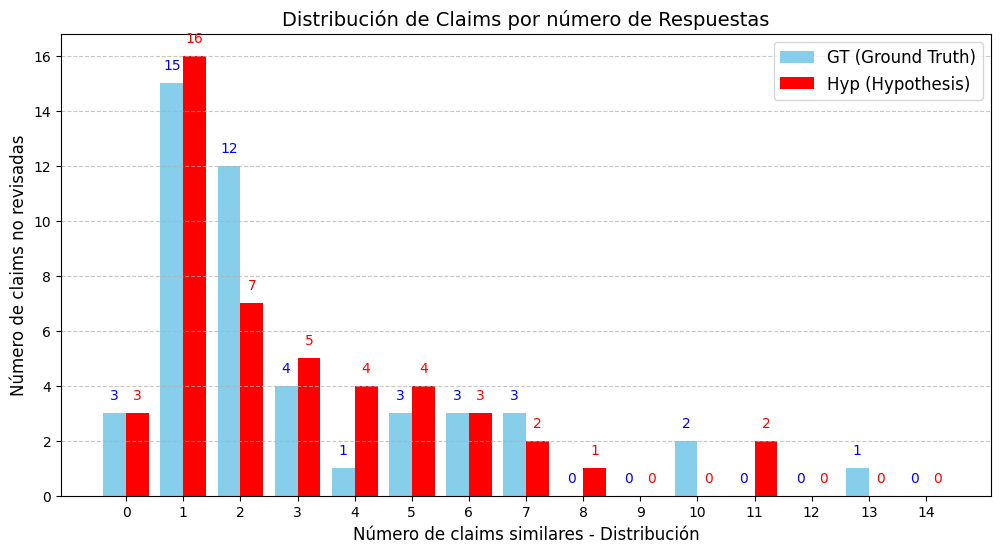

In [ ]:


x = [x for x in range(15)]  # Longitud de respuestas
y_gt = [items_count.get(key, 0) for key in x]  # Número de claims (GT)
y_hyp = [items_count_results.get(key, 0) for key in x]  # Número de claims (Hyp)
print(y_hyp)

# Configuración de posición de las barras
x_pos = range(len(x))
width = 0.4  # Ancho de las barras

plt.figure(figsize=(12, 6))
plt.bar([pos - width / 2 for pos in x_pos], y_gt, width, color='skyblue', label='GT (Ground Truth)')
plt.bar([pos + width / 2 for pos in x_pos], y_hyp, width, color='red', label='Hyp (Hypothesis)')

plt.xlabel("Número de claims similares - Distribución", fontsize=12)
plt.ylabel("Número de claims no revisadas", fontsize=12)
plt.title("Distribución de Claims por número de Respuestas", fontsize=14)
plt.xticks(x_pos, x)  # Etiquetas del eje x
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Añadir números encima de las barras (GT)
for i, value in enumerate(y_gt):
    plt.text(i - width / 2, value + 0.5, str(value), ha='center', fontsize=10, color='blue')

# Añadir números encima de las barras (Hyp)
for i, value in enumerate(y_hyp):
    plt.text(i + width / 2, value + 0.5, str(value), ha='center', fontsize=10, color='red')

plt.legend(fontsize=12)
plt.show()


## Compute Metrics and Accuracy

Evaluates the pipeline's performance using multiple metrics:
- **MAP@k**: Measures the precision of the top-K predictions at cutoff values (`k_values`).
- **Recall@k**: Evaluates the recall of the top-K predictions, indicating the proportion of relevant items retrieved.
- **MRR**: Calculates the Mean Reciprocal Rank, reflecting how quickly the correct items appear in the ranked list.
- **Accuracy**: Computes the overall accuracy of the predictions compared to the ground truth.

The computed metrics and accuracy are printed to summarize the model's performance.


In [43]:
k_values = [1, 3, 5, 10]
map_scores = map_at_k(query_answer_dict, results, k_values)
recall_scores = recall_at_k(query_answer_dict, results, k_values)
mrr_score = mean_reciprocal_rank(query_answer_dict, results)
accuracy = calculate_accuracy_pipeline(query_answer_dict, results)

# Pretty print the results
print("Metrics Report:")
print("-" * 30)
print("Mean Average Precision (MAP@k):")
for k, score in zip(k_values, map_scores):
    print(f"  MAP@{k}: {score:.4f}")
print("\nRecall@k:")
for k, score in zip(k_values, recall_scores):
    print(f"  Recall@{k}: {score:.4f}")
print("\nMean Reciprocal Rank (MRR):")
print(f"  MRR: {mrr_score:.4f}")
print("\nOverall Accuracy:")
print(f"  Accuracy: {accuracy:.2f}")



Metrics Report:
------------------------------
Mean Average Precision (MAP@k):
  MAP@1: 0.8936
  MAP@3: 0.8044
  MAP@5: 0.7837
  MAP@10: 0.7653

Recall@k:
  Recall@1: 0.8936
  Recall@3: 0.8262
  Recall@5: 0.8319
  Recall@10: 0.8155

Mean Reciprocal Rank (MRR):
  MRR: 0.9191

Overall Accuracy:
  Accuracy: 0.64


# Inference

In [31]:
def get_prob_from_str(user_input, k_rev_claims):
     # Prepare input for Hugging Face model
    inputs = tokenizer(
        [user_input] * len(k_rev_claims),  # Duplicate query for all top-k claims
        k_rev_claims[archive].tolist(),   # Corresponding archives
        max_length=MAX_TOKENS,
        padding=True,
        truncation=True,
        return_tensors="pt"
    )
    
    # Move inputs to the device of the model (e.g., GPU)
    inputs = {key: val.to(model.device) for key, val in inputs.items()}
    
    # Predict probabilities using Hugging Face model
    with torch.no_grad():
        outputs = model(**inputs)
        is_similar_proba = torch.softmax(outputs.logits, dim=-1)[:, 1].cpu().numpy()  # Probability of class 1
        return is_similar_proba

In [32]:
df = filtered_test
query_user =  df[df["similarity"] == 1][query_col].sample(n=1).iloc[0]
print(query_user)

Reino Unido deja de recomendar la vacunación anticovid en embarazadas


In [33]:
def get_query(query_user):
    print("Calculando similitudes...")
    query_embedding = embedding_model.encode(query_user, convert_to_tensor=True)
    candidate_similarities = [
        (j, util.cos_sim(query_embedding, archive_embedding).item())
        for j, archive_embedding in enumerate(df['archive_embedding'])
    ]
    unreviewed_claim = query_user

    top_k = [x[0] for x in heapq.nlargest(topK, candidate_similarities, key=lambda x: x[1])]
    k_rev_claims = filtered_test.iloc[top_k]#[archive]
    # Now we have the topK rev claim by similarity. We can classify them now
    is_similar_proba = get_prob_from_str(unreviewed_claim, k_rev_claims)
    indices = np.where(np.array(is_similar_proba) >= TH)[0]

    sorted_indices = sorted(indices, key=lambda x: is_similar_proba[x], reverse=True)
    selected_rev_claims = k_rev_claims.iloc[sorted_indices][archive].tolist()
    results = []
    set_claims = set()
    for i, rev_claim in enumerate(selected_rev_claims):
        if rev_claim not in set_claims:
            results.append((rev_claim, is_similar_proba[sorted_indices[i]]))
            print(rev_claim, f"  [{is_similar_proba[sorted_indices[i]]*100.0:.2f} confidence]")
            set_claims.add(rev_claim)
    return results


In [ ]:


# CSS para estilizar la salida
style = HTML("""
    <style>
        .result-box {
            font-family: Arial, sans-serif;
            background-color: #f9f9f9;
            border: 1px solid #ddd;
            border-radius: 5px;
            padding: 15px;
            margin-top: 10px;
            width: 100%;
        }
        .result-title {
            font-size: 18px;
            font-weight: bold;
            color: #333;
            margin-bottom: 10px;
        }
        .result-item {
            font-size: 16px;
            margin-bottom: 5px;
        }
        .result-item span {
            font-weight: bold;
        }
    </style>
""")

input_box = widgets.Text(
    value='',
    placeholder='Enter your claim here...',
    description='Claim:',
    layout=widgets.Layout(width='100%'),
    style={'description_width': 'initial'}
)

submit_button = widgets.Button(
    description="Submit Query",
    button_style="primary",  # 'success', 'info', 'warning', 'danger' or '' for default
    tooltip="Click to submit your claim",
    icon="search"
)

output = widgets.Output()

def on_submit_button_click(b):
    query_user = input_box.value  
    if not query_user.strip():
        with output:
            clear_output()
            print("Please enter a valid claim.")
        return
    
    results = get_query(query_user)
    
    with output:
        clear_output()
        display(HTML("<div class='result-box'>"
                     f"<div class='result-title'>Results for: \"{query_user}\"</div>"
                     + "".join([f"<div class='result-item'>Claim: <span>{claim}</span> | Probability: <span>{prob:.2f}</span></div>"
                                for claim, prob in results])
                     + "</div>"))

submit_button.on_click(on_submit_button_click)

display(style, input_box, submit_button, output)


Text(value='', description='Claim:', layout=Layout(width='100%'), placeholder='Enter your claim here...', styl…

Button(button_style='primary', description='Submit Query', icon='search', style=ButtonStyle(), tooltip='Click …

Output()

## 💡 Discussion

- **Experimenting with Other Models:** While `Qwen2.5` performed well, experimenting with larger Qwen models or recently released models like `LLama 3.3` or `phi4` could yield better results.
- **Using More Data:** Attempts were made to include additional metadata and reviewed claim details as input to `Qwen2.5`. However, this significantly increased computation time (as the experiments were run on a laptop) and did not improve results. There is potential for further exploration in this area.
- **Vector Databases:** Tools like LangChain and vector databases such as LanceDB or FAISS could be integrated to create a robust vector-based retrieval system for finding similar documents efficiently.